In [17]:
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

from xgboost import XGBClassifier
import joblib


In [18]:
# Adjust this if your root is different
PROJECT_ROOT = Path("/Users/sai/Desktop/lab_predictors")

DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

DATA_PROCESSED


PosixPath('/Users/sai/Desktop/lab_predictors/data/processed')

In [19]:
df = pd.read_parquet(DATA_PROCESSED / "patient_table_with_clusters.parquet")
df.head()


,patient_id,label_ckd,label_cvd,label_anemia,label_predm,age,sex,albumin_latest,alt_latest,ast_latest,...,glucose_latest,hba1c_latest,hdl_latest,hematocrit_latest,hemoglobin_latest,ldl_latest,protein_latest,rdw_latest,triglycerides_latest,cluster
0,0002056e-c7bf-d8e4-ac3d-06ed0176f880,0,0,0,0,31,0,NaN,NaN,NaN,...,NaN,NaN,52.62,44.295,16.110,86.61,NaN,NaN,133.11,0
1,0002056e-c7bf-d8e4-ac3d-06ed0176f880,0,0,0,0,31,0,NaN,NaN,NaN,...,NaN,NaN,52.62,44.295,16.110,86.61,NaN,NaN,133.11,0
2,0005284e-05db-bdaf-cf43-ca9490dcf2c0,0,0,0,0,66,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,000659c5-295f-9100-2472-547b0213ec02,0,1,1,1,63,1,NaN,NaN,NaN,...,78.31,5.88,28.71,32.715,11.841,130.69,NaN,NaN,129.53,0
4,000659c5-295f-9100-2472-547b0213ec02,0,1,1,1,63,1,NaN,NaN,NaN,...,78.31,5.88,28.71,32.715,11.841,130.69,NaN,NaN,129.53,0


In [20]:
df_model = df.copy()

# Drop ID (we don't want models to "learn" patient_id)
if "patient_id" in df_model.columns:
    df_model = df_model.drop(columns=["patient_id"])

# Encode sex (M/F -> 1/0) if it's still string
if df_model["sex"].dtype == "O":
    df_model["sex"] = df_model["sex"].map({"M": 1, "F": 0})

In [21]:
df_model.isna().mean().sort_values(ascending=False).head(20)


ast_latest                  0.999221
rdw_latest                  0.999221
alt_latest                  0.999221
protein_latest              0.929667
bilirubin_latest            0.929667
albumin_latest              0.929200
egfr_latest                 0.908443
hba1c_latest                0.852520
glucose_latest              0.842667
bun_latest                  0.831334
creatinine_latest           0.831334
cholesterol_total_latest    0.778293
ldl_latest                  0.778293
triglycerides_latest        0.778293
hdl_latest                  0.778293
hemoglobin_latest           0.642262
hematocrit_latest           0.642262
label_ckd                   0.000000
label_cvd                   0.000000
sex                         0.000000
dtype: float64

In [22]:
cols_to_drop = [
    "ast_latest", "alt_latest", "rdw_latest",
    "protein_latest", "bilirubin_latest", "albumin_latest"
]

df_model = df_model.drop(columns=cols_to_drop, errors="ignore")


In [23]:
label_columns = ["label_ckd", "label_cvd", "label_anemia", "label_predm"]

# Every other column is a feature (including "cluster")
feature_cols = [c for c in df_model.columns if c not in label_columns]

print("Features used:", feature_cols)


Features used: ['age', 'sex', 'bun_latest', 'cholesterol_total_latest', 'creatinine_latest', 'egfr_latest', 'glucose_latest', 'hba1c_latest', 'hdl_latest', 'hematocrit_latest', 'hemoglobin_latest', 'ldl_latest', 'triglycerides_latest', 'cluster']


In [24]:
def train_xgb_model(df, target_label, feature_cols, test_size=0.2, random_state=42):
    """
    df: dataframe with features + labels
    target_label: one of 'label_ckd', 'label_cvd', 'label_anemia', 'label_predm'
    feature_cols: list of feature column names to use as X
    """

    print(f"\n=== Training model for {target_label} ===")

    X = df[feature_cols]
    y = df[target_label]

    # Show label balance
    print("Label distribution:\n", y.value_counts(normalize=True).round(3))

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    model = XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.03,
        colsample_bytree=0.8,
        subsample=0.8,
        eval_metric="logloss",
        tree_method="hist",  # Fast
        use_label_encoder=False
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    print("AUC:", round(auc, 3))
    print(classification_report(y_test, y_pred, digits=3))

    return model

In [25]:
model_ckd    = train_xgb_model(df_model, "label_ckd",    feature_cols)
model_cvd    = train_xgb_model(df_model, "label_cvd",    feature_cols)
model_anemia = train_xgb_model(df_model, "label_anemia", feature_cols)
model_predm  = train_xgb_model(df_model, "label_predm",  feature_cols)


=== Training model for label_ckd ===
Label distribution:
 label_ckd
0    0.971
1    0.029
Name: proportion, dtype: float64


/Users/sai/Desktop/lab_predictors/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:08:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 1.0
              precision    recall  f1-score   support

           0      0.999     1.000     0.999      4985
           1      1.000     0.967     0.983       151

    accuracy                          0.999      5136
   macro avg      0.999     0.983     0.991      5136
weighted avg      0.999     0.999     0.999      5136


=== Training model for label_cvd ===
Label distribution:
 label_cvd
0    0.894
1    0.106
Name: proportion, dtype: float64


/Users/sai/Desktop/lab_predictors/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:08:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.994
              precision    recall  f1-score   support

           0      0.981     0.992     0.987      4594
           1      0.929     0.841     0.883       542

    accuracy                          0.976      5136
   macro avg      0.955     0.917     0.935      5136
weighted avg      0.976     0.976     0.976      5136


=== Training model for label_anemia ===
Label distribution:
 label_anemia
0    0.878
1    0.122
Name: proportion, dtype: float64


/Users/sai/Desktop/lab_predictors/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:08:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.995
              precision    recall  f1-score   support

           0      0.990     0.985     0.987      4507
           1      0.896     0.928     0.912       629

    accuracy                          0.978      5136
   macro avg      0.943     0.957     0.950      5136
weighted avg      0.978     0.978     0.978      5136


=== Training model for label_predm ===
Label distribution:
 label_predm
0    0.864
1    0.136
Name: proportion, dtype: float64


/Users/sai/Desktop/lab_predictors/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:08:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 1.0
              precision    recall  f1-score   support

           0      0.999     0.999     0.999      4438
           1      0.996     0.994     0.995       698

    accuracy                          0.999      5136
   macro avg      0.997     0.997     0.997      5136
weighted avg      0.999     0.999     0.999      5136



In [26]:
import shap

# Enable JS visualization (for some notebook environments)
shap.initjs()


In [27]:
# Use a subset of the data as background for SHAP
X_all = df_model[feature_cols]

# If dataset is big, sample 200–500 rows
background = X_all.sample(n=300, random_state=42)


In [28]:
def explain_model_with_shap(model, X, model_name="model", max_display=15):
    """
    model: trained XGBoost model
    X: full feature matrix (pd.DataFrame) you want to explain on
    model_name: label for titles
    max_display: max number of features to show in plots
    """
    print(f"\n=== SHAP analysis for {model_name} ===")

    explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
    shap_values = explainer.shap_values(X)

    # 1) Bar plot of mean absolute SHAP values (global importance)
    shap.summary_plot(
        shap_values,
        X,
        plot_type="bar",
        max_display=max_display,
        show=True
    )

    # 2) Detailed summary plot (beeswarm style)
    shap.summary_plot(
        shap_values,
        X,
        max_display=max_display,
        show=True
    )

    return explainer, shap_values



=== SHAP analysis for CKD (label_ckd) ===


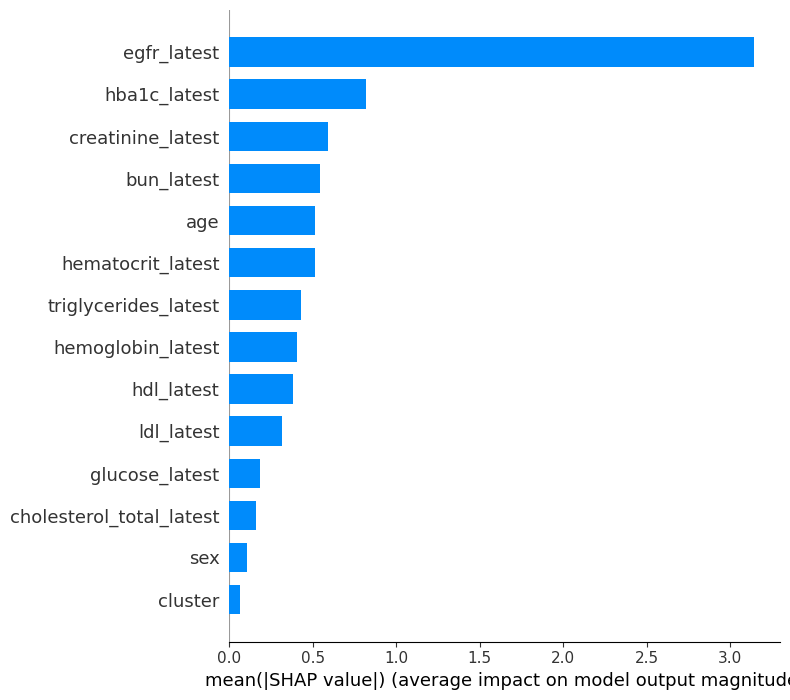

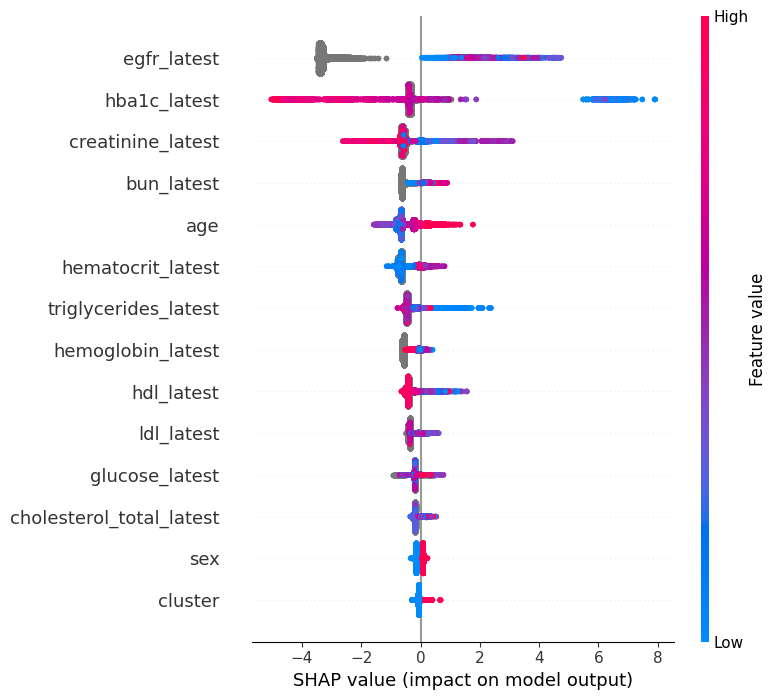

In [29]:
X_ckd = X_all.copy()
explainer_ckd, shap_ckd = explain_model_with_shap(
    model_ckd,
    X_ckd,
    model_name="CKD (label_ckd)",
    max_display=15
)



=== SHAP analysis for CVD (label_cvd) ===


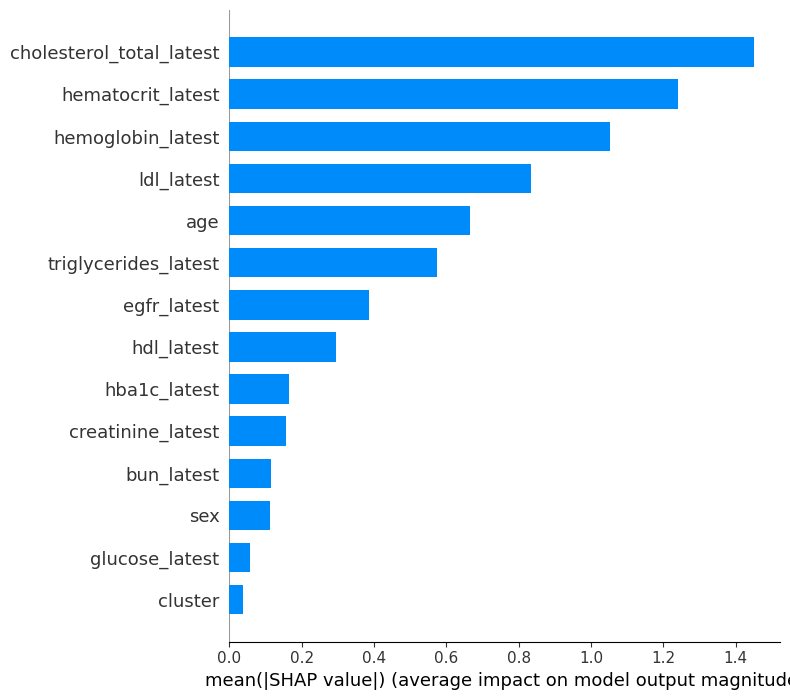

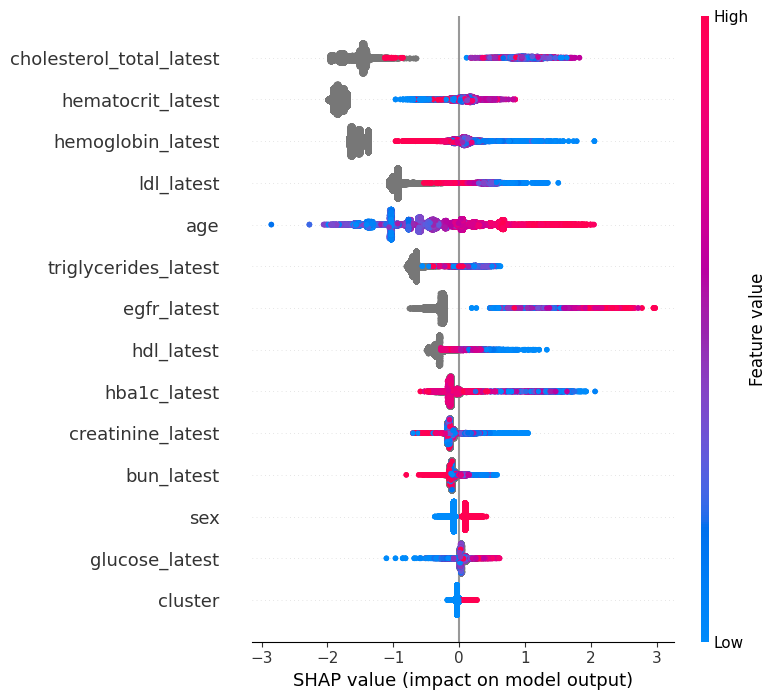

In [30]:
X_cvd = X_all.copy()
explainer_cvd, shap_cvd = explain_model_with_shap(
    model_cvd,
    X_cvd,
    model_name="CVD (label_cvd)",
    max_display=15
)



=== SHAP analysis for Anemia (label_anemia) ===


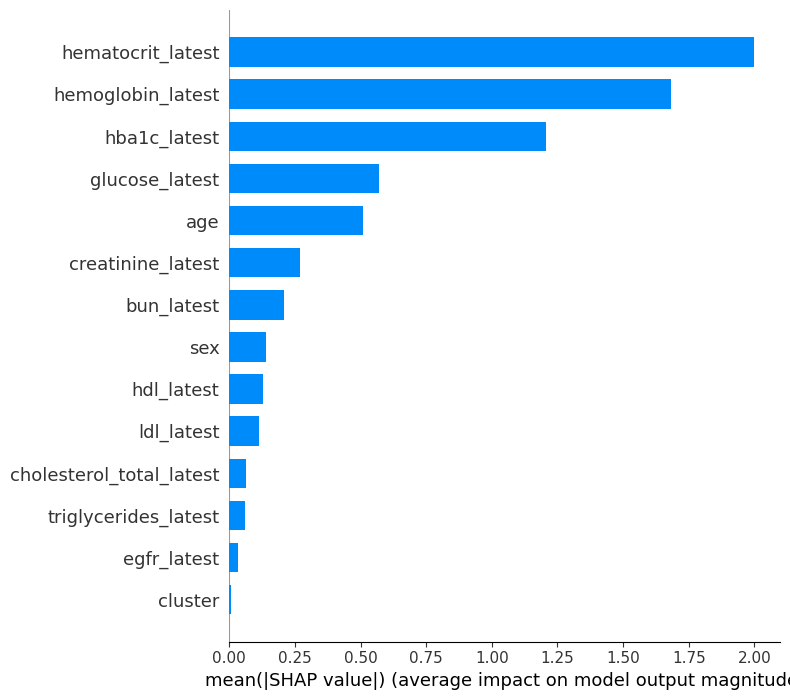

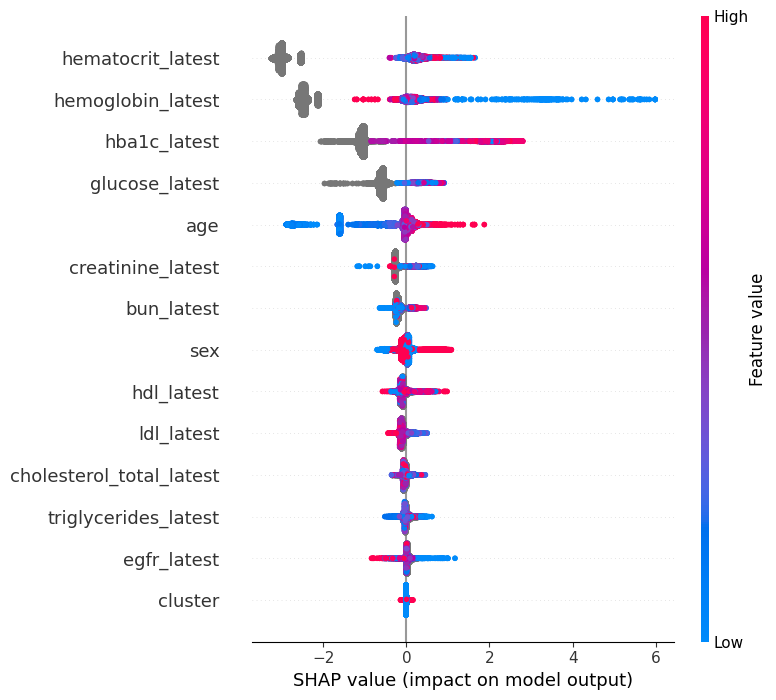

In [31]:
X_anemia = X_all.copy()
explainer_anemia, shap_anemia = explain_model_with_shap(
    model_anemia,
    X_anemia,
    model_name="Anemia (label_anemia)",
    max_display=15
)



=== SHAP analysis for Prediabetes (label_predm) ===


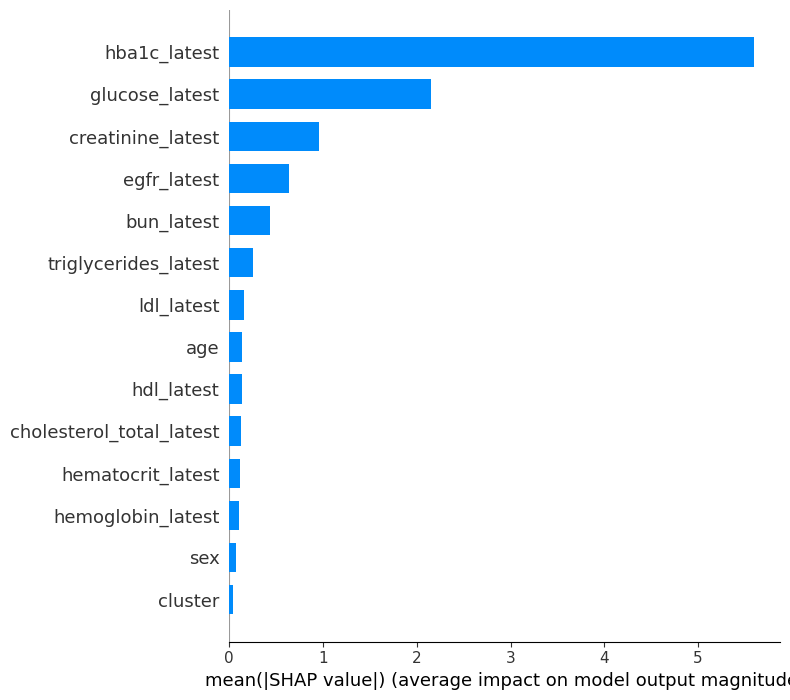

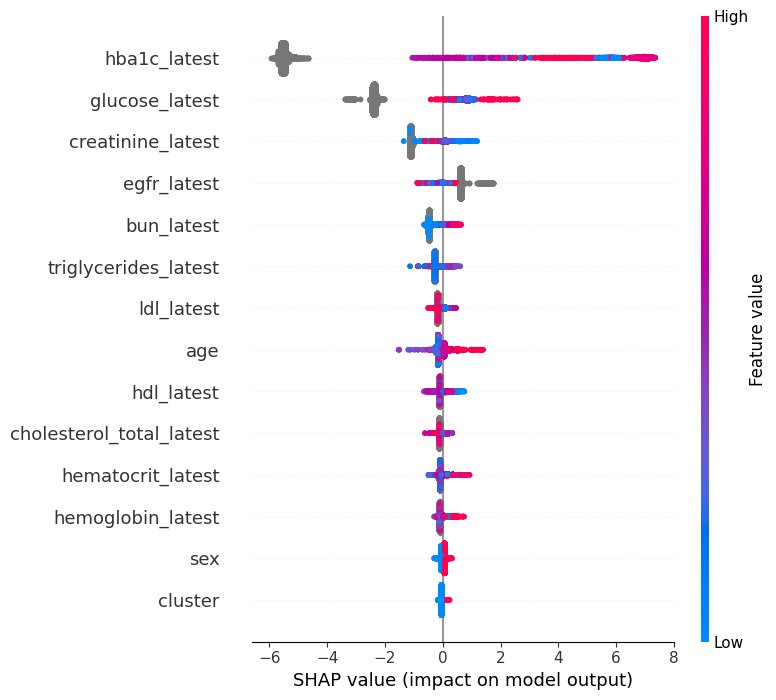

In [32]:
X_predm = X_all.copy()
explainer_predm, shap_predm = explain_model_with_shap(
    model_predm,
    X_predm,
    model_name="Prediabetes (label_predm)",
    max_display=15
)


In [33]:
from pathlib import Path
import json

# ---------------------------------------------------
# Define the path to your prediction folder
# ---------------------------------------------------
PREDICTION_DIR = Path("/Users/sai/Desktop/lab_predictors/models/prediction")
PREDICTION_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------
# Save all 4 models
# ---------------------------------------------------
model_ckd.save_model(PREDICTION_DIR / "xgb_ckd_model.json")
model_cvd.save_model(PREDICTION_DIR / "xgb_cvd_model.json")
model_anemia.save_model(PREDICTION_DIR / "xgb_anemia_model.json")
model_predm.save_model(PREDICTION_DIR / "xgb_predm_model.json")

print("All models successfully saved to:", PREDICTION_DIR)

# ---------------------------------------------------
# Save feature column order (IMPORTANT for inference)
# ---------------------------------------------------
feature_list_path = PREDICTION_DIR / "feature_columns.json"

with open(feature_list_path, "w") as f:
    json.dump(feature_cols, f)

print("Saved feature order to:", feature_list_path)


All models successfully saved to: /Users/sai/Desktop/lab_predictors/models/prediction
Saved feature order to: /Users/sai/Desktop/lab_predictors/models/prediction/feature_columns.json
